In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, anderson, kstest, norm, zscore, mannwhitneyu, spearmanr, chi2_contingency, t, ks_1samp, kruskal
from scipy.interpolate import make_interp_spline
from sklearn.feature_selection import mutual_info_regression
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
import seaborn as sns
import os
pd.set_option('display.max_colwidth', None)

In [2]:
main_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path = main_path + "\\data\\raw\\"
path_fig = main_path + "\\reports\\figures\\"

In [3]:
df_list = [
    'album.xlsx', 'artist.xlsx', 'customer.xlsx', 'employee.xlsx',
    'genre.xlsx', 'invoice.xlsx', 'invoiceline.xlsx', 'mediatype.xlsx',
    'playlist.xlsx', 'playlisttrack.xlsx', 'track.xlsx'
]

df_album = pd.read_excel(path + df_list[0])
df_artist = pd.read_excel(path + df_list[1])
df_customer = pd.read_excel(path + df_list[2])
df_employee = pd.read_excel(path + df_list[3])
df_genre = pd.read_excel(path + df_list[4])
df_invoice = pd.read_excel(path + df_list[5])
df_invoiceline= pd.read_excel(path + df_list[6])
df_mediatype = pd.read_excel(path + df_list[7])
df_playlist = pd.read_excel(path + df_list[8])
df_playlisttrack = pd.read_excel(path + df_list[9])
df_track = pd.read_excel(path + df_list[10])

## Describe and info for all tables.

In [4]:
def extract_info(df, name):
    dtype_counts = df.dtypes.value_counts().to_dict()

    return pd.DataFrame({
        "DataFrame": name,
        "Columns": [list(df.columns)],
        "Rows": [df.shape[0]],
        "Dtype Count": [dtype_counts]
    })

In [5]:
total_info_list =[]
desc_list = []

for df_name in df_list:
    df = pd.read_excel(path + df_name)
    df = df.drop(['Unnamed: 0'], axis=1)

    name = df_name.split('.')[0]
    total_info_list.append(extract_info(df, name))

    desc_list.append(df.describe())

total_info = pd.concat(total_info_list, ignore_index=True)
total_describe = pd.concat(desc_list, keys=[df.split(".")[0] for df in df_list])

## Investigation of track, genre, album DataFrames

In [6]:
df_track_genre_album = pd.merge(pd.merge(df_track, df_genre, on='GenreId'), 
                                df_album,
                                on='AlbumId'
                            )
df_track_genre_album.columns

Index(['Unnamed: 0_x', 'TrackId', 'Name_x', 'AlbumId', 'MediaTypeId',
       'GenreId', 'Composer', 'Milliseconds', 'Bytes', 'UnitPrice',
       'Unnamed: 0_y', 'Name_y', 'Unnamed: 0', 'Title', 'ArtistId'],
      dtype='object')

In [7]:
df_track_genre_album = df_track_genre_album.rename(columns={"Name_x": "NameTrack", "Name_y": "NameGenre"})
df_track_genre_album = df_track_genre_album[['TrackId', 'NameTrack', 'GenreId', 'NameGenre',  'Title', 'UnitPrice', 'TrackId']]
df_track_genre_album

,TrackId,NameTrack,GenreId,NameGenre,Title,UnitPrice,TrackId
0,1,For Those About To Rock (We Salute You),1,Rock,For Those About To Rock We Salute You,0.99,1
1,2,Balls to the Wall,1,Rock,Balls to the Wall,0.99,2
2,3,Fast As a Shark,1,Rock,Restless and Wild,0.99,3
3,4,Restless and Wild,1,Rock,Restless and Wild,0.99,4
4,5,Princess of the Dawn,1,Rock,Restless and Wild,0.99,5
...,...,...,...,...,...,...,...
3498,3499,Pini Di Roma (Pinien Von Rom) I Pini Della Via Appia,24,Classical,Respighi:Pines of Rome,0.99,3499
3499,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quartettsatz"": II. Andante - Allegro assai",24,Classical,Schubert: The Late String Quartets & String Quintet (3 CD's),0.99,3500
3500,3501,"L'orfeo, Act 3, Sinfonia (Orchestra)",24,Classical,Monteverdi: L'Orfeo,0.99,3501
3501,3502,"Quintet for Horn, Violin, 2 Violas, and Cello in E Flat Major, K. 407/386c: III. Allegro",24,Classical,Mozart: Chamber Music,0.99,3502


### <ul><li> Names of genres </li></ul>

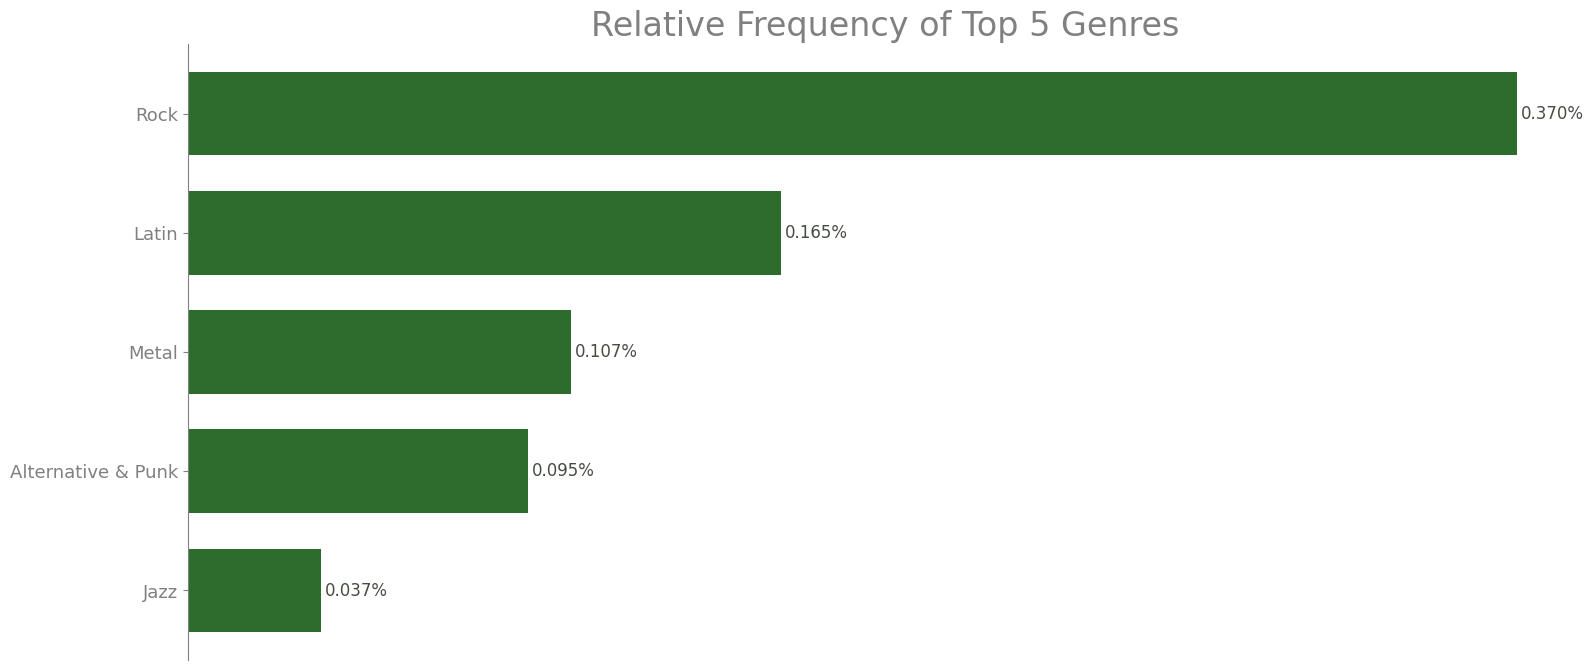

In [8]:
fig, ax = plt.subplots(figsize=(18, 8))

data_NameGenre = df_track_genre_album['NameGenre'].value_counts(normalize=True).sort_values()
mask_NameGenre = data_NameGenre >  0.03

bars = ax.barh(data_NameGenre[mask_NameGenre].index, 
              data_NameGenre[mask_NameGenre].values,
              height=0.7,
              align='center',
              color="#2e6c2e")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')


ax.bar_label(bars, fmt='%.3f%%', fontsize=12, color='#454d43', padding=3)

# ax.set_xlabel(reshaped_labelx,  fontsize=16, color='gray', loc='left')
# ax.set_ylabel("Genre", fontsize=16, color='gray', loc='center')


ax.set_title("Relative Frequency of Top 5 Genres", fontsize=24, loc="center", color="gray")

plt.xticks([]) 
plt.yticks(fontsize=13) 
plt.savefig(path_fig + "genre.png", format="png", transparent=True, dpi=400)
plt.show()

#### <ul><li> Total unit price for each album </li></ul>

In [9]:
df_album_unitprice = (df_track_genre_album.groupby(['Title'], as_index=False)
                    .agg(TotalUnitPrice=('UnitPrice', 'sum'))
                    .sort_values(by=['TotalUnitPrice'], ascending=True))

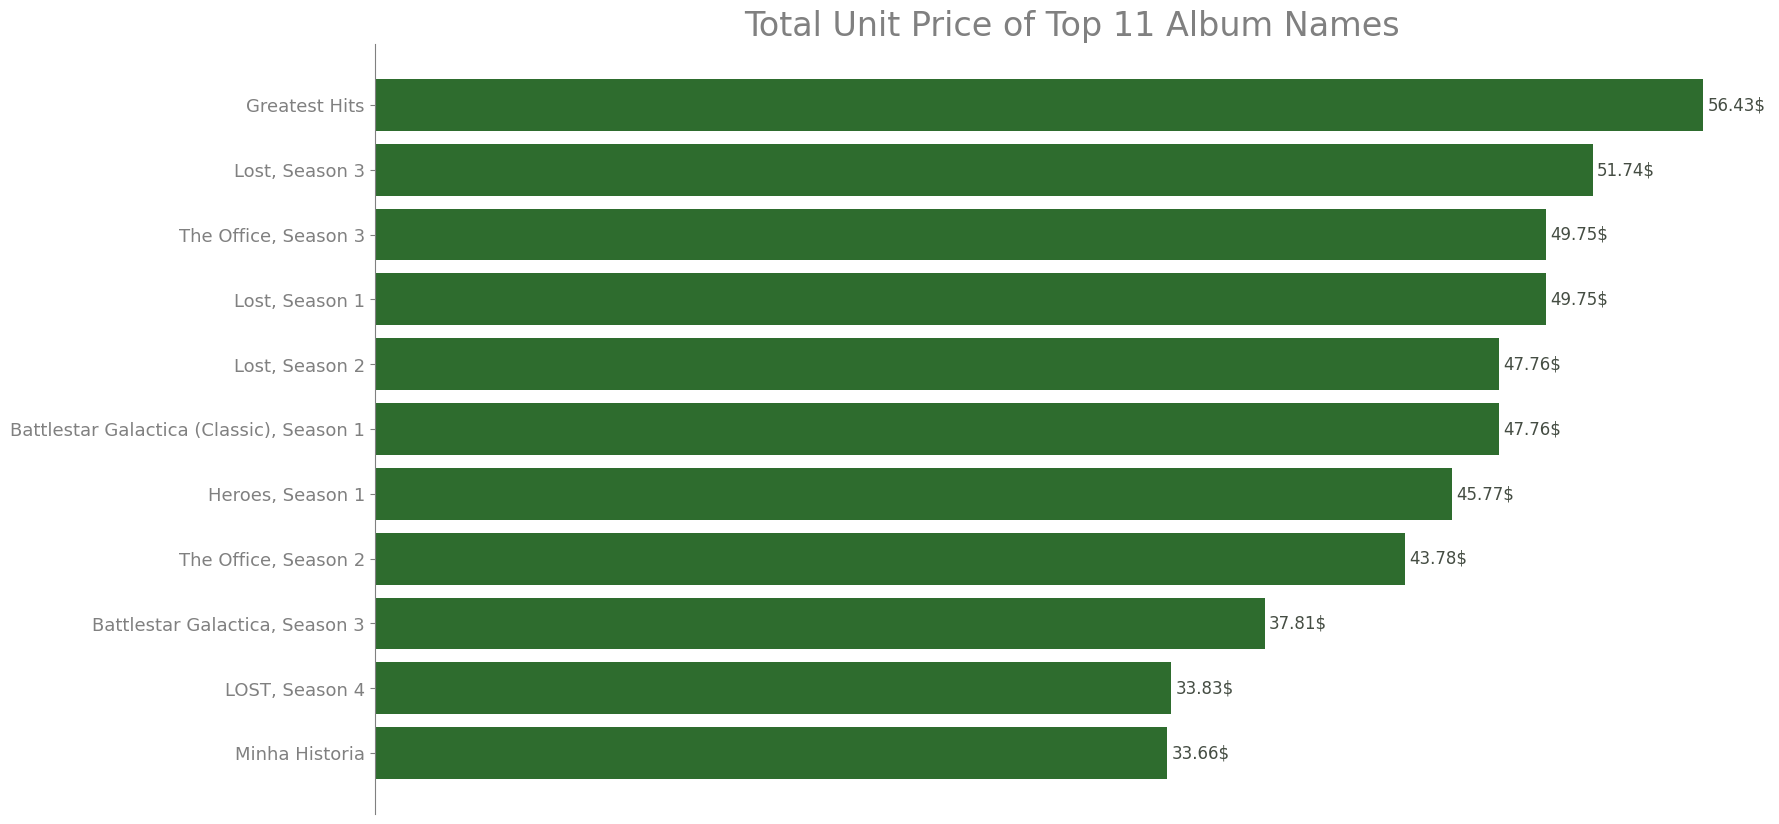

In [10]:
fig, ax = plt.subplots(figsize=(18, 10))

bars = ax.barh(df_album_unitprice.query('TotalUnitPrice > 30')['Title'], 
              df_album_unitprice.query('TotalUnitPrice > 30')['TotalUnitPrice'],
              height=0.8,
              align='center',
              color="#2e6c2e",
              )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')


ax.bar_label(bars, fmt='%.2f$', fontsize=12, color='#454d43', padding=3)

# ax.set_xlabel(reshaped_labelx,  fontsize=16, color='gray', loc='left')
# ax.set_ylabel("Genre", fontsize=16, color='gray', loc='center')


ax.set_title("Total Unit Price of Top 11 Album Names", fontsize=24, loc="center", color="gray")

plt.xticks([]) 
plt.yticks(fontsize=13) 
plt.savefig(path_fig + "album.png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
plt.show()

## Investigation of invoice DataFrame

In [11]:
df_invoice = df_invoice.assign(InvoiceDateYear= lambda df: df['InvoiceDate'].dt.year,
                               InvoiceYearMonth= lambda df: df["InvoiceDate"].dt.strftime("%Y-%b")
                               )

In [12]:
df_invoice_MeanTotalBuy = (df_invoice
                            .groupby(by=['InvoiceDateYear', 'InvoiceYearMonth'], as_index=False)
                            .agg(TotalBuy=('Total', 'sum'))
                            .groupby(by=['InvoiceDateYear'], as_index=False)
                            .agg(MeanTotalBuy=('TotalBuy', 'mean')))

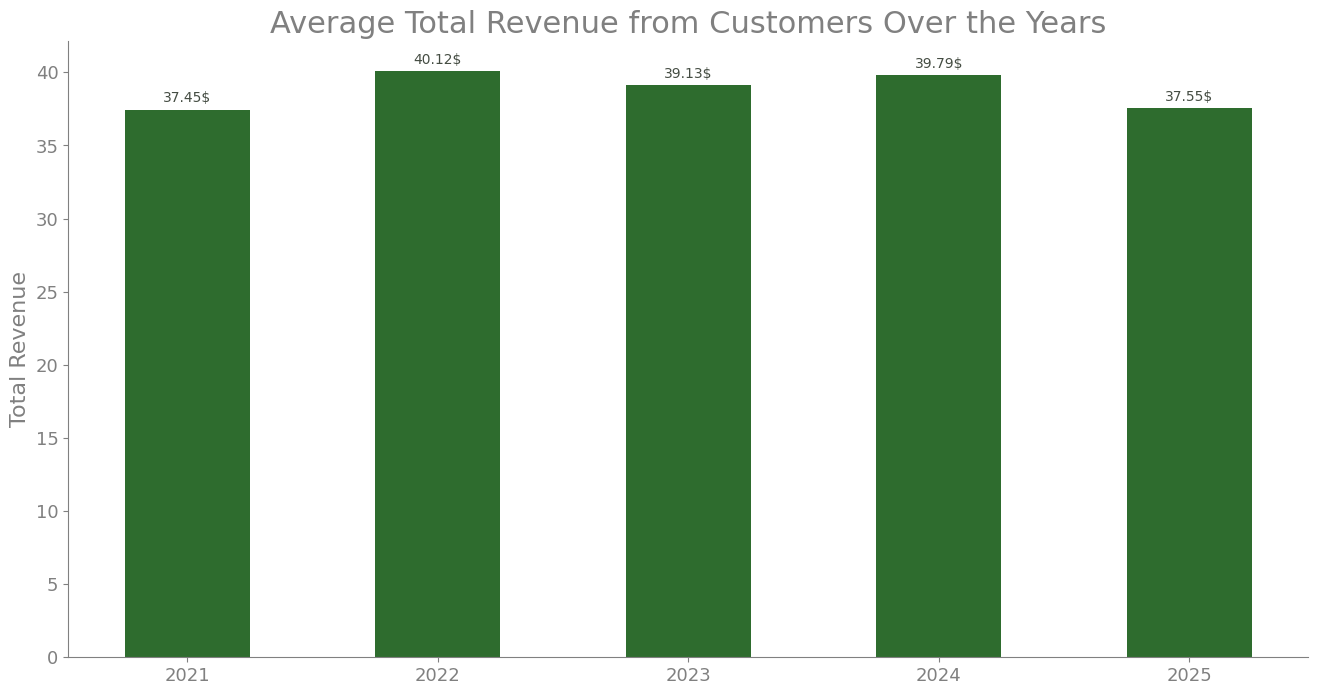

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.bar(df_invoice_MeanTotalBuy['InvoiceDateYear'], 
              df_invoice_MeanTotalBuy['MeanTotalBuy'],
              width=0.5,
              align='center',
              color="#2e6c2e",
              )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(colors='gray', labelsize=13) 

ax.bar_label(bars, fmt='%.2f$', fontsize=10, color='#454d43', padding=3)

# ax.set_xlabel("fgh",  fontsize=16, color='gray', loc='left')
ax.set_ylabel("Total Revenue", fontsize=16, color='gray', loc='center')


ax.set_title("Average Total Revenue from Customers Over the Years", fontsize=22, loc="center", color="gray")

plt.savefig(path_fig + "total_revenue_to_years.png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
plt.show()

In [14]:
df_invoice_date_to_Total = df_invoice.groupby(by=['InvoiceDateYear', 'InvoiceYearMonth'], as_index=False).agg(TotalBuy=('Total', 'sum'))

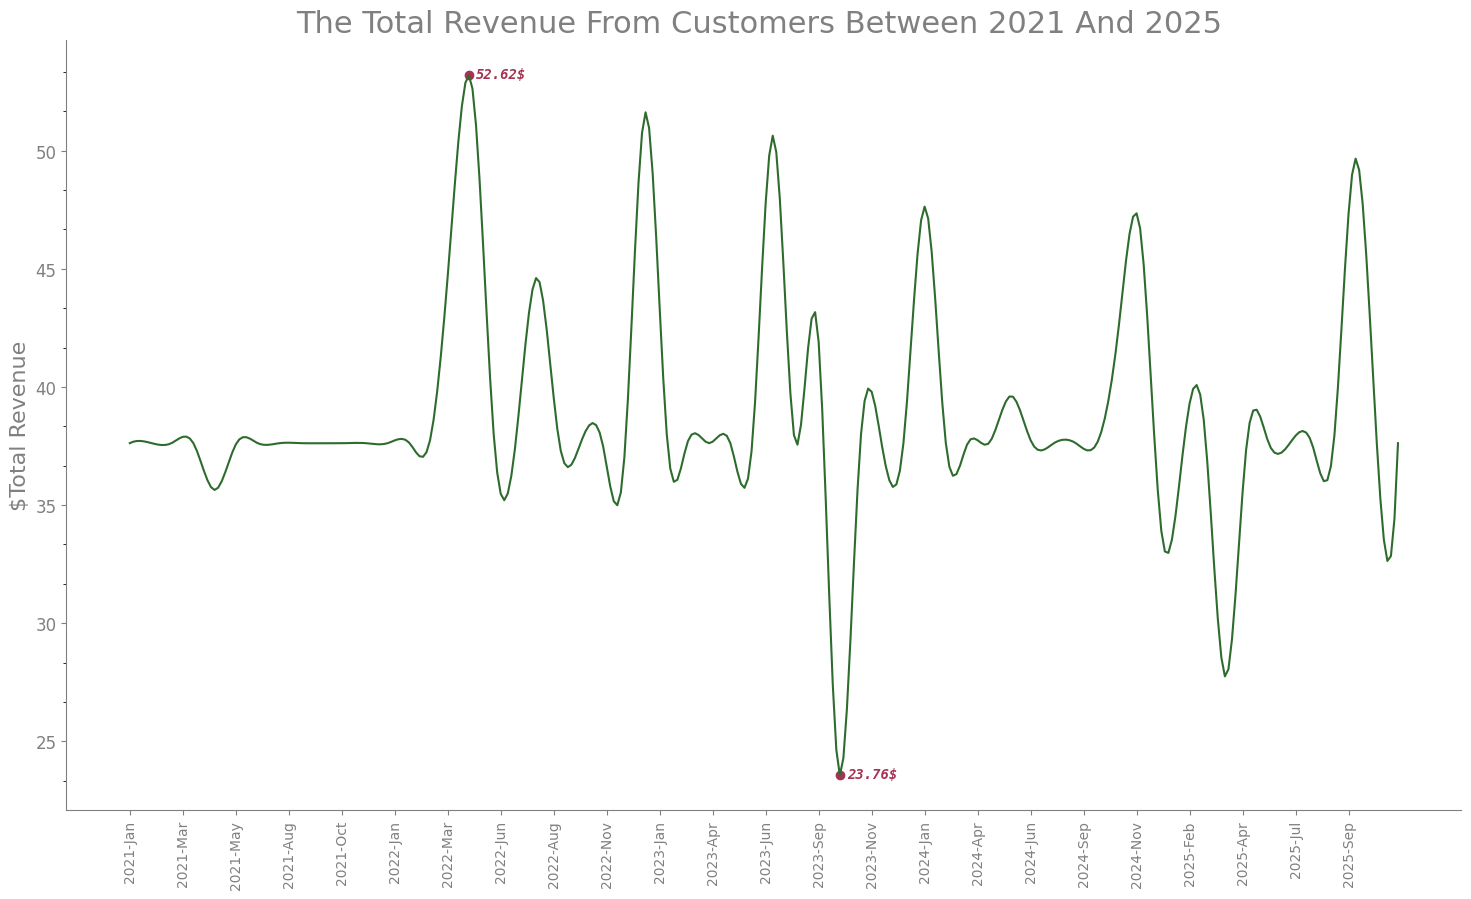

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))

df_InvoiceYearMonth = pd.to_datetime(df_invoice_date_to_Total["InvoiceYearMonth"], format="%Y-%b").sort_values()
x_numeric = df_InvoiceYearMonth.map(pd.Timestamp.toordinal)

x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 360)  
y_smooth = make_interp_spline(x_numeric, df_invoice_date_to_Total['TotalBuy'])(x_smooth)

ax.plot(x_smooth, y_smooth, linewidth=1.5, color="#2e6c2e")

ax.scatter(x_smooth[201], y_smooth[201], c='#a63354')
ax.text(x_smooth[201]+10, y_smooth[201]-.1, 
        f"{df_invoice_date_to_Total.query('InvoiceDateYear == 2023 and TotalBuy == TotalBuy.min()')['TotalBuy'].values[0]}$",
        weight='bold', color='#a63354', style='italic', fontfamily='monospace')

ax.scatter(x_smooth[96], y_smooth[96], c='#a63354')
ax.text(x_smooth[96]+10, y_smooth[96]-.1, 
        f"{df_invoice_date_to_Total.query('InvoiceDateYear == 2022 and TotalBuy == TotalBuy.max()')['TotalBuy'].values[0]}$",
        weight='bold', color='#a63354', style='italic', fontfamily='monospace')

x_labels = [pd.Timestamp.fromordinal(int(x)).strftime("%Y-%b") for x in x_smooth[::15]] 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')

ax.set_ylabel("$Total Revenue", fontsize=16, color='gray', loc='center')

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(3))  

ax.set_title("The Total Revenue From Customers Between 2021 And 2025 ", fontsize=22, loc="center", color="gray")

ax.set_xticks(x_smooth[::15], x_labels, rotation=90)
plt.yticks(fontsize=12) 

plt.savefig(path_fig + "total_revenue_to_years(LineChart).png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
plt.show()

## Normality of Numerical Features

In [16]:
def test_normality(df_col : pd.Series):

        print(f"Normality Test for '{df_col.name}':\n")
        
        data = np.random.normal(loc=0, scale=1, size=1000)  

        stat1, p1 = shapiro(df_col.dropna())  
        print(f"Shapiro-Wilk Test: p={p1:.5f} { 'Not Normal' if p1 < 0.05 else 'Normal'}")

        result = anderson(df_col.dropna(), dist='norm')
        crit_val_5 = result.critical_values[2] 
        print(f"Anderson-Darling Test: crit_val={crit_val_5:.5f} {'Not Normal (p=0.05)' if result.statistic > crit_val_5 else 'Normal (p=0.05)'}")

        
        stat3, p3 = ks_1samp(df_col.dropna(), norm.cdf, args=(np.mean(data), np.std(data)))
        print(f"K-S Test: p={p3:.5f} {'Not Normal' if p3 < 0.05 else 'Normal'}")

In [17]:
def plot_hist(df_col : pd.Series):

    fig, ax = plt.subplots(figsize=(18, 8))

    sns.histplot(df_col, kde=True, ax=ax, color="#2e6c2e")


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    ax.tick_params(axis='x', colors='gray') 
    ax.tick_params(axis='y', colors='gray')


    ax.set_xlabel(df_col.name,  fontsize=17, color='gray', loc='left')
    ax.set_ylabel("Count", fontsize=17, color='gray', loc='bottom')

    ax.set_title(f"Histogram of '{df_col.name}' Column (mean:{df_col.mean():.2f}, median:{df_col.median():.2f})",
                 fontsize=22,
                 loc="center", 
                 color="gray")

    ax.tick_params(axis='y', labelsize=13)

    plt.savefig(path_fig + f"Histogram_of_{df_col.name}.png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
    plt.show()

In [18]:
def plot_box(df_col : pd.Series, mask=False):

    fig, ax = plt.subplots(figsize=(18, 3))

    sns.boxplot(df_col, orient='h', color="#2e6c2e", ax=ax)
    
    if mask is not False:
        ax.scatter(df_col[mask], np.zeros([len(df_col[mask])]), color='#d44686')

    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines['bottom'].set_color('gray')

    ax.tick_params(axis='x', colors='gray') 

    ax.set_xlabel('')

    ax.set_title(f"Box Plot of '{df_col.name}' Column (mean:{df_col.mean():.2f}, median:{df_col.median():.2f})",
                 fontsize=20,
                 loc="center", 
                 color="gray")

    plt.savefig(path_fig + f"BoxPlot_of_{df_col.name}.png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
    plt.show()

#### <ul><li> "df_track" Dataframe </li></ul>

In [19]:
test_normality(df_track['UnitPrice'])
#plot_hist(df_track['UnitPrice'])

Normality Test for 'UnitPrice':

Shapiro-Wilk Test: p=0.00000 Not Normal
Anderson-Darling Test: crit_val=0.78600 Not Normal (p=0.05)
K-S Test: p=0.00000 Not Normal


Normality Test for 'Bytes':

Shapiro-Wilk Test: p=0.00000 Not Normal
Anderson-Darling Test: crit_val=0.78600 Not Normal (p=0.05)
K-S Test: p=0.00000 Not Normal


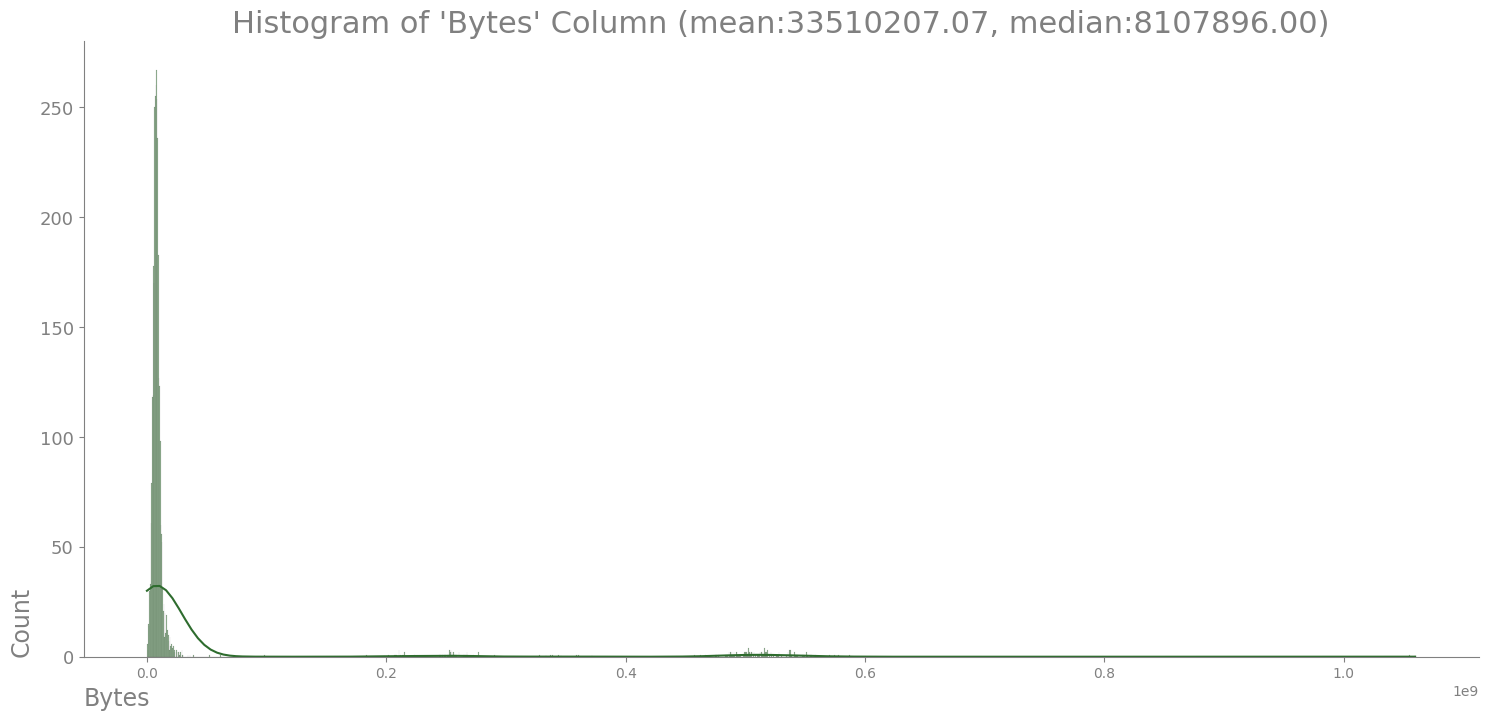

In [20]:
test_normality(df_track['Bytes'])
plot_hist(df_track['Bytes'])

##### Outliers above 1E9 make sense, so we remove those points.

Before remove outliers:


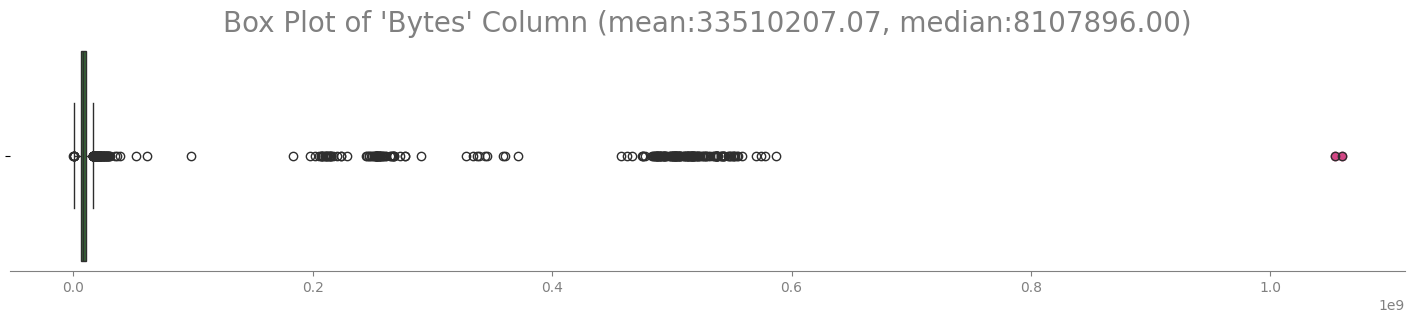

After remove outliers:


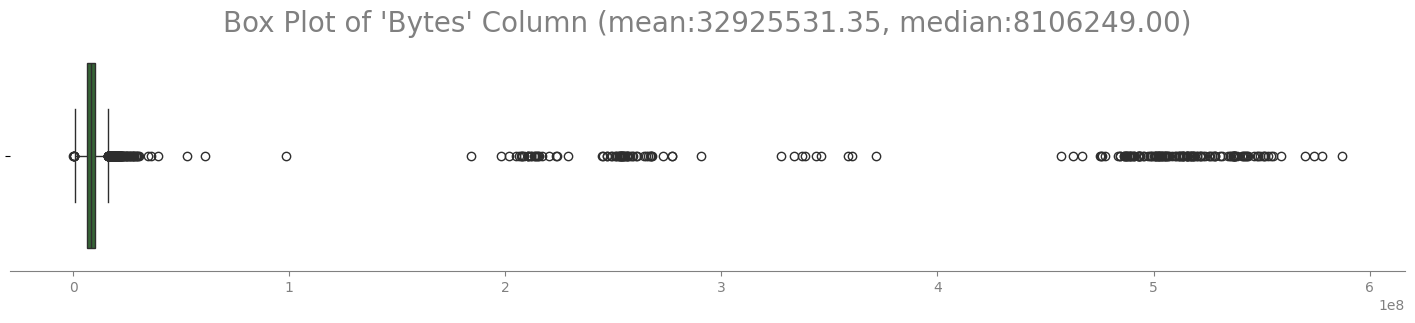

In [21]:
print("Before remove outliers:")
plot_box(df_track['Bytes'], mask=df_track['Bytes'] > 1e9)

print("After remove outliers:")
plot_box(df_track['Bytes'][df_track['Bytes'] < 1e9])

Normality Test for 'Milliseconds':

Shapiro-Wilk Test: p=0.00000 Not Normal
Anderson-Darling Test: crit_val=0.78600 Not Normal (p=0.05)
K-S Test: p=0.00000 Not Normal


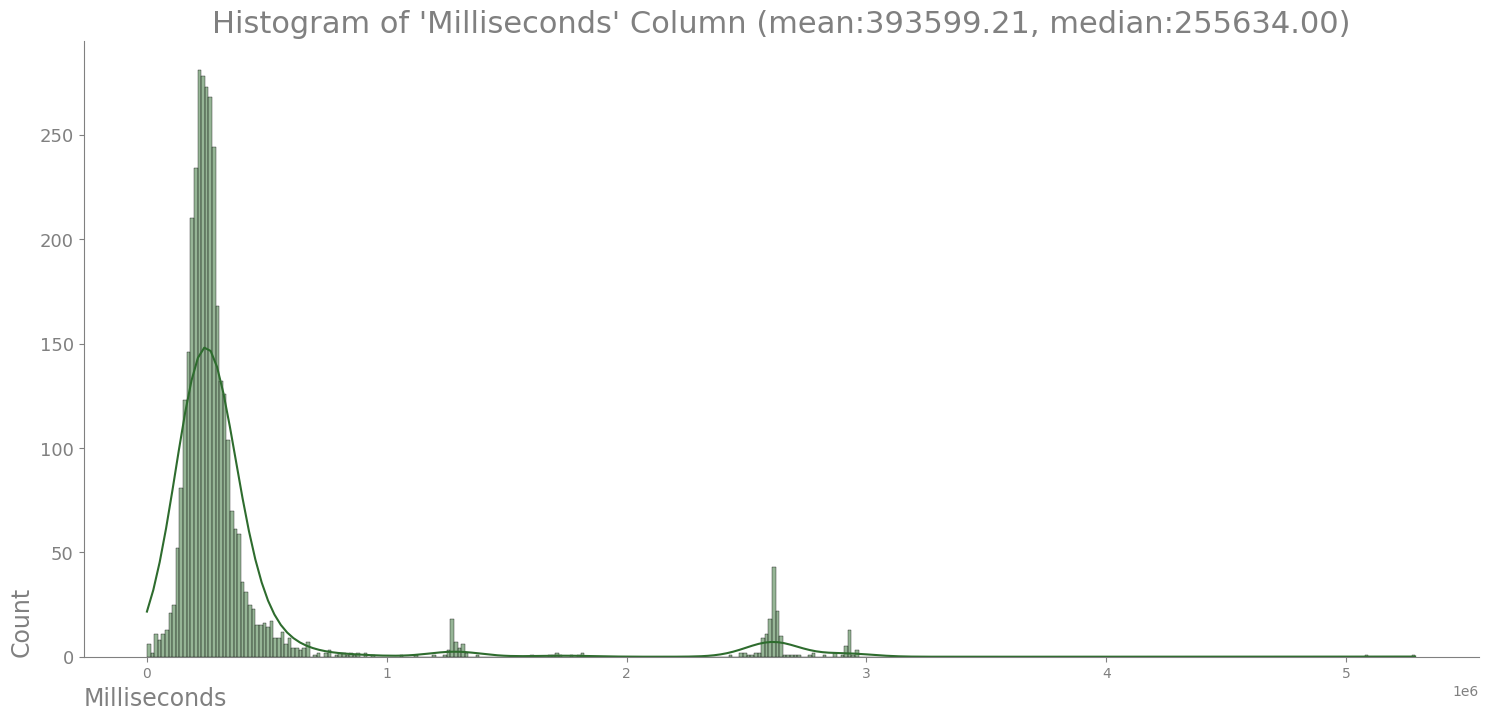

In [22]:
test_normality(df_track['Milliseconds'])
plot_hist(df_track['Milliseconds'])

##### Outliers above 5E6 make sense, so we remove those points.

Before remove outliers:


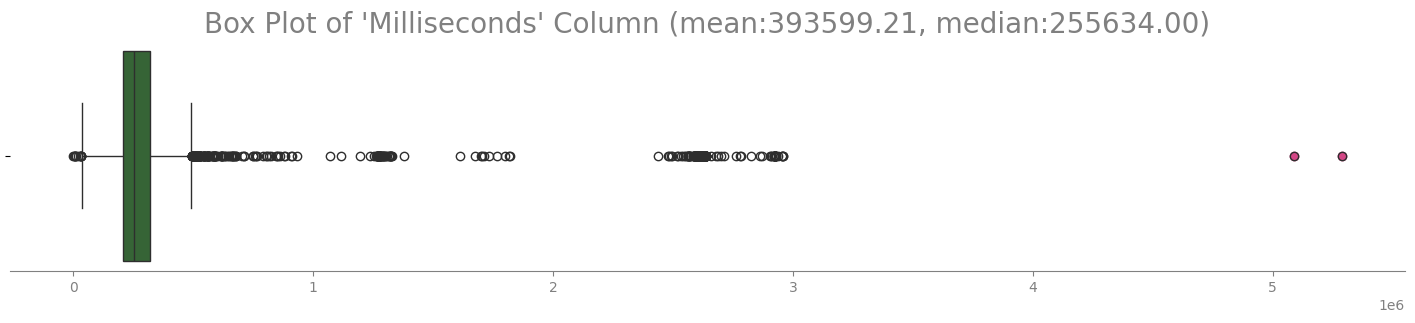

After remove outliers:


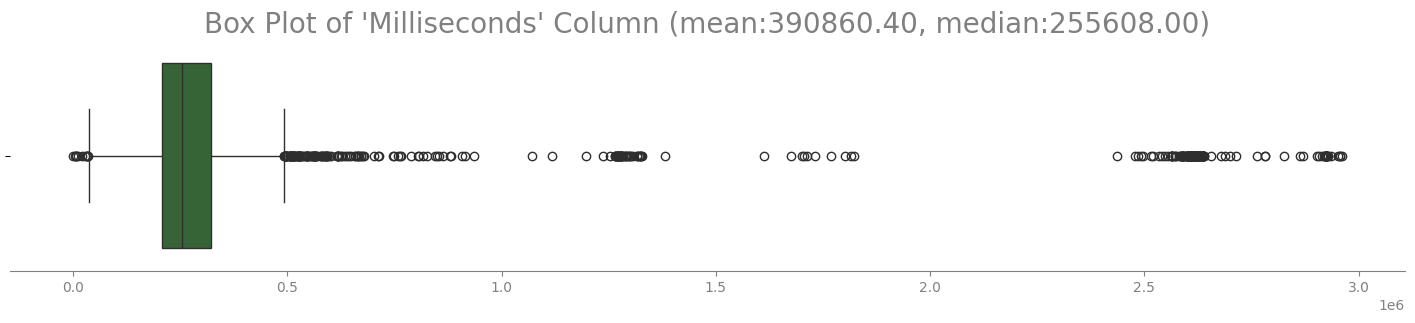

In [23]:
print("Before remove outliers:")
plot_box(df_track['Milliseconds'], mask=df_track['Milliseconds'] > 5e6)

print("After remove outliers:")
plot_box(df_track['Milliseconds'][df_track['Milliseconds'] <= 5e6])

#### <ul><li> "df_invoiceline" Dataframe </li></ul>

In [24]:
test_normality(df_invoiceline['UnitPrice'])
#plot_hist(df_invoiceline['UnitPrice'])

Normality Test for 'UnitPrice':

Shapiro-Wilk Test: p=0.00000 Not Normal
Anderson-Darling Test: crit_val=0.78600 Not Normal (p=0.05)
K-S Test: p=0.00000 Not Normal


#### <ul><li> "df_invoice" Dataframe </li></ul>

Normality Test for 'Total':

Shapiro-Wilk Test: p=0.00000 Not Normal
Anderson-Darling Test: crit_val=0.78000 Not Normal (p=0.05)
K-S Test: p=0.00000 Not Normal


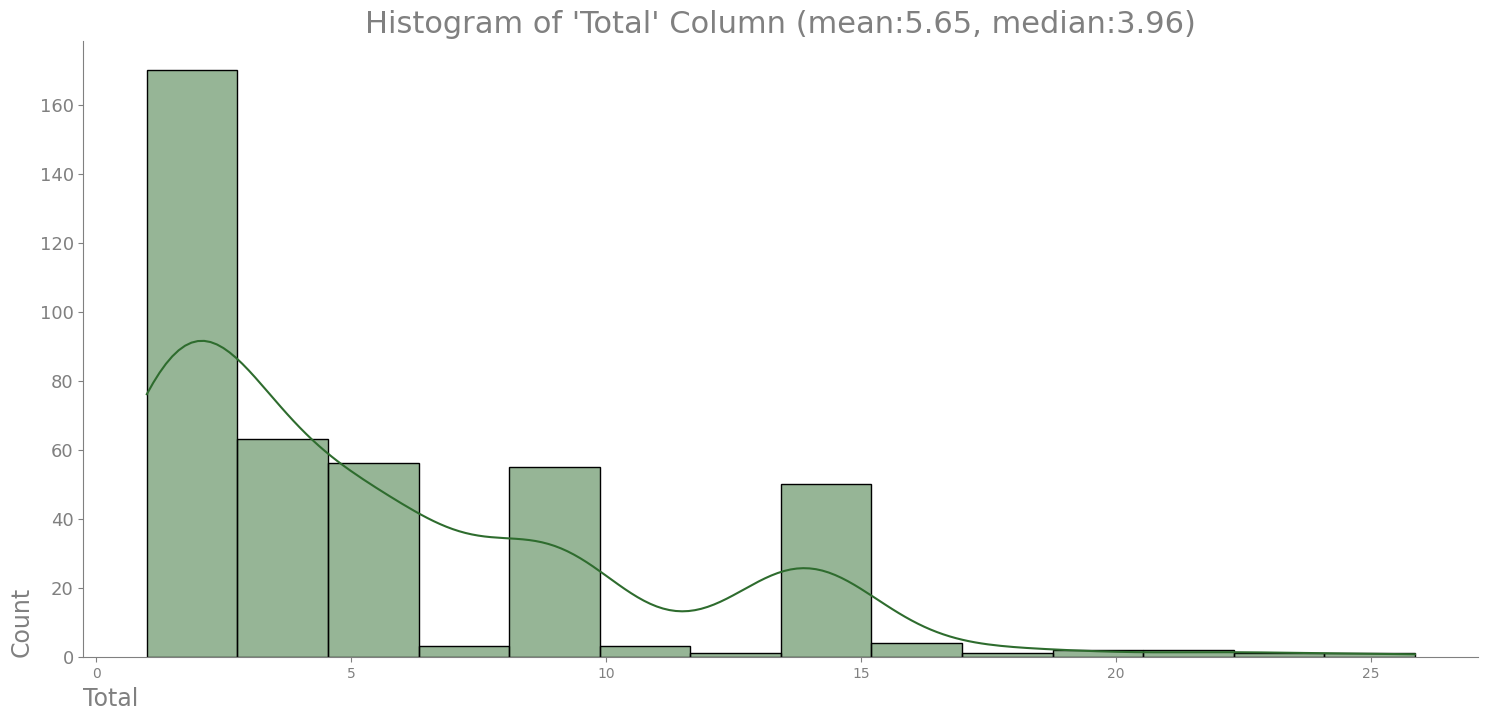

In [25]:
test_normality(df_invoice['Total'])
plot_hist(df_invoice['Total'])

Before remove outliers:


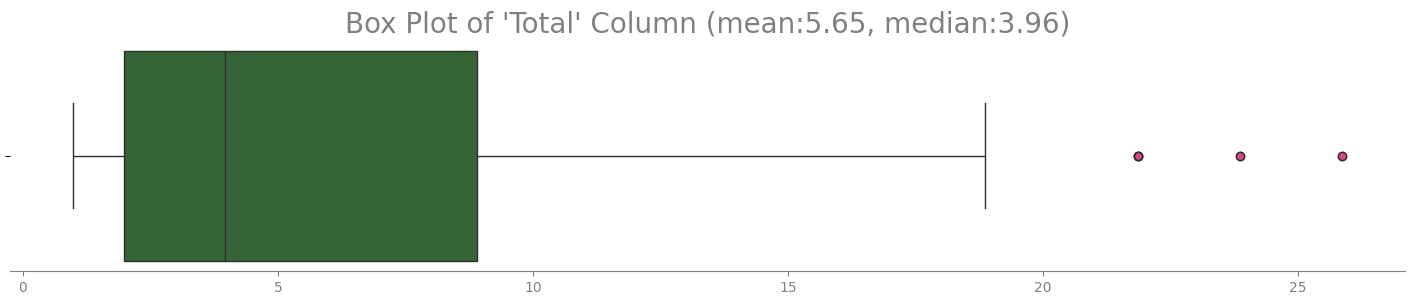

After remove outliers:


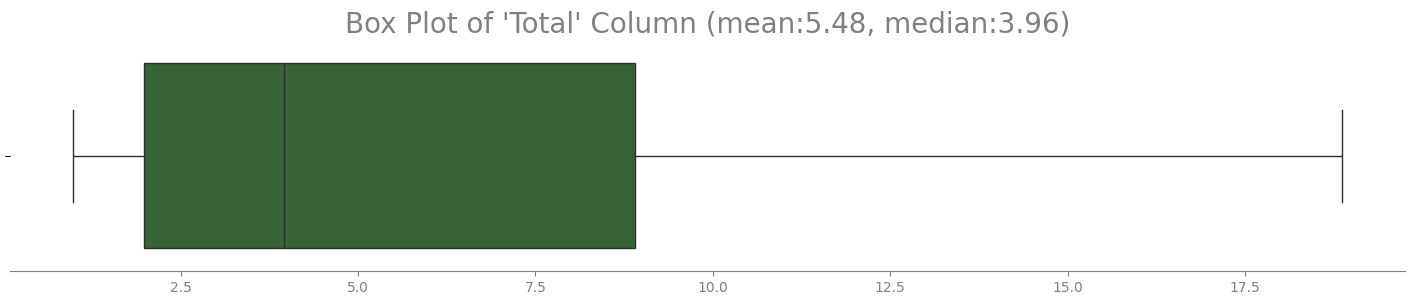

In [26]:
print("Before remove outliers:")
plot_box(df_invoice['Total'], mask=df_invoice['Total'] > 20.0)

print("After remove outliers:")
plot_box(df_invoice['Total'][df_invoice['Total'] <= 20.0])

## 3 Popular genres

In [53]:
df_invoiceline_invoice = pd.merge(df_invoiceline, df_invoice , on='InvoiceId')[['TrackId', 'Total', 'UnitPrice', 'Quantity']]

df_track_invoiceline_genre = pd.merge(pd.merge(df_track, df_invoiceline_invoice, on='TrackId'),
                                               df_genre, on='GenreId')

df_track_invoiceline_genre = df_track_invoiceline_genre.rename(columns={'Name_y': 'NameGenre', 'UnitPrice_x': 'UnitPrice'})

df_track_invoiceline_genre['TotalPrice'] = df_track_invoiceline_genre['UnitPrice'] * df_track_invoiceline_genre['Quantity']

grp_df_track_invoiceline_genre = (df_track_invoiceline_genre
                                .groupby(by=['NameGenre'], as_index=False)
                                .agg(SumTotalPrice=('Total', 'sum'))
                                .sort_values(by=['SumTotalPrice'], ascending=False)
                                .head(3))
grp_df_track_invoiceline_genre

,NameGenre,SumTotalPrice
17,Rock,7720.02
12,Latin,3472.55
13,Metal,2093.13


In [52]:
#### <li>Two distributions 'Rock' , 'Latin'

# print(f"Mean of distribution TotalPrice for genre 'Rock' and 'Latin':\
#  {df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Rock')]['TotalPrice'].mean().round(3)}\
# , {df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Latin')]['TotalPrice'].mean().round(3)}\n")


# stat, p = mannwhitneyu(df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Rock')]['TotalPrice'],
#                        df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Latin')]['TotalPrice'],
#                        alternative='two-sided')

# print(f"Mann-Whitney U test: p={p:.5f} {'Significantly  difference' if p < 0.05 else 'No significantly difference'}")

#### <li>Three distributions 'Latin' , 'Metal', 'Rock'

In [47]:
print(f"Mean of distribution TotalPrice for genre 'Latin', 'Metal' and 'Rock:\
 {df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Latin')]['Total'].mean().round(3)}\
, {df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Metal')]['Total'].mean().round(3)}\
, {df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Rock')]['Total'].mean().round(3)}\n")

stat, p = kruskal(df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Latin')]['Total'],
                       df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Metal')]['Total'],
                       df_track_invoiceline_genre[df_track_invoiceline_genre['NameGenre'].eq('Rock')]['Total'])

print(f"Kruskal-Wallis Test: p={p:.5f} {'Significantly  difference' if p < 0.05 else 'No significantly difference'}")

Mean of distribution TotalPrice for genre 'Latin', 'Metal' and 'Rock: 8.996, 7.929, 9.246

Kruskal-Wallis Test: p=0.00047 Significantly  difference


## Dependency between 'Milliseconds', 'UnitPrice'

In [54]:
df_track_invoiceline_genre[['Milliseconds', 'UnitPrice']].corr(method='spearman')

,Milliseconds,UnitPrice
Milliseconds,1.000000,0.375827
UnitPrice,0.375827,1.000000


In [55]:
spearman_corr, spearman_p = spearmanr(df_track_invoiceline_genre['Milliseconds'], df_track_invoiceline_genre['UnitPrice'])
print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Spearman Correlation: 0.3758, p-value: 0.0000


In [69]:
mi = mutual_info_regression(df_track_invoiceline_genre[['Milliseconds']], df_track_invoiceline_genre['UnitPrice'])
print(f"Mutual Information Score: {mi[0]:.4f}")

Mutual Information Score: 0.2051


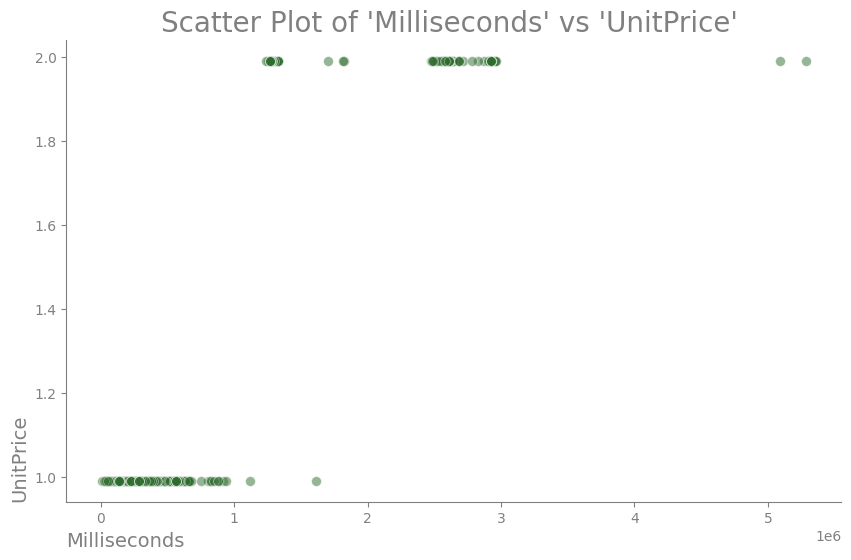

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(x=df_track_invoiceline_genre['Milliseconds'], y=df_track_invoiceline_genre['UnitPrice'],
                color="#2e6c2e",
                s=50, 
                alpha=.5)

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('gray')

ax.tick_params(colors='gray') 

ax.set_title(f"Scatter Plot of 'Milliseconds' vs 'UnitPrice' ",
            fontsize=20,
            loc="center", 
            color="gray")

ax.set_xlabel('Milliseconds',  fontsize=14, color='gray', loc='left')
ax.set_ylabel('UnitPrice', fontsize=14, color='gray', loc='bottom')

plt.savefig(path_fig + "ScatterPlot.png", format="png", transparent=True ,bbox_inches='tight', dpi=400)
plt.show()


##### The analysis results indicate a weak dependency between the two distributions.

## Number of songs purchased by male and female 

In [71]:
detector = gender.Detector()

df_invoiceline_invoice_customer = (df_invoiceline
                                    .merge(df_invoice, on='InvoiceId')
                                    .merge(df_customer, on='CustomerId')[['CustomerId', 'FirstName', 'LastName', 'Quantity']]
                                    .assign(FullName= lambda df: df['FirstName'] + ' ' + df['LastName'],
                                            Gender= lambda df: df['FirstName'].apply(lambda name: detector.get_gender(name)),
                                            CleanedGender= lambda df: df['Gender'].replace({
                                                'male': 'M',
                                                'female': 'F',
                                                'mostly_male': 'M',
                                                'mostly_female': 'F',
                                                'andy': 'Androgynous',
                                                'unknown': 'Unknown'
                                            }))
                                    
                                    )


In [72]:
total_buy_gender = (df_invoiceline_invoice_customer
                    .query("CleanedGender == 'M' or CleanedGender == 'F'")
                    .groupby(by=['CleanedGender'], as_index=False)
                    .agg(TotalBuy=('Quantity', 'sum')))

In [73]:
total_buy_gender

,CleanedGender,TotalBuy
0,F,684
1,M,1444


## Dependency Of song genre, media type and track name

In [247]:
df_track_genre_mediatype = (df_track
                            .merge(df_genre, on='GenreId', suffixes=("Track", "Genre"))
                            .merge(df_mediatype, on='MediaTypeId'))[['NameTrack', 'NameGenre', 'Name']]


chi2, p, _, _ = chi2_contingency(pd.crosstab(df_track_genre_mediatype['NameGenre'], df_track_genre_mediatype['Name']))
print(f"Chi2 test: p={p:.5f} {'variables NameGenre and Name are independent' if p < 0.05 else 'variables are dependent'}")

Chi2 test: p=0.00000 variables NameGenre and Name are independent


In [248]:
chi2, p, _, _ = chi2_contingency(pd.crosstab(df_track_genre_mediatype['NameGenre'], df_track_genre_mediatype['NameTrack']))
print(f"Chi2 test: p={p:.5f} {'variables NameGenre and NameTrack are independent' if p < 0.05 else 'variables are dependent'}")


Chi2 test: p=0.00000 variables NameGenre and NameTrack are independent


In [249]:
, p, _, _ = chi2_contingency(pd.crosstab(df_track_genre_mediatype['Name'], df_track_genre_mediatype['NameTrack']))
print(f"Chi2 test: p={p:.5f} {'variables Name and NameTrack are independent' if p < 0.05 else 'variables are dependent'}")

Chi2 test: p=0.00000 variables Name and NameTrack are independent


## Average length of songs in different genres

In [298]:
def confidence(df_col, size):
    mean = df_col.mean()
    std = df_col.std()
    n = len(df_col)
    sem = std / np.sqrt(n) 

    confidence = 0.95
    alpha = 1 - confidence

    if size < 30:
        t_critical = t.ppf(1 - alpha/2, df=n-1)  
        margin_of_error = t_critical * sem
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error
    
    else:
        z_critical = norm.ppf(1 - alpha/2)  
        margin_of_error = z_critical * sem
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error

    if pd.isna(upper_bound) or pd.isna(lower_bound):
        upper_bound =  lower_bound = mean

    return lower_bound.round(3), upper_bound.round(3)

In [361]:
df_track_genre = df_track.merge(df_genre, on='GenreId', suffixes=("Track", "Genre"))[['NameGenre', 'Milliseconds']]
grp_df_track_genre = (df_track_genre.groupby(by=['NameGenre'], as_index=False).agg(CountLength=('Milliseconds', 'count'),
                                                                                  MeanLength=('Milliseconds', 'mean')))
                                                                              
grp_df_track_genre['MeanLength'] = grp_df_track_genre['MeanLength'].round(3)          

grp_df_track_genre[['LowerCI', 'UpperCI']] = grp_df_track_genre.apply(
                lambda df: pd.Series(confidence(df_track_genre[df_track_genre['NameGenre'] == df['NameGenre']]['Milliseconds'], df['CountLength'])),
                axis=1
            )


grp_df_track_genre = grp_df_track_genre.drop(['CountLength'], axis=1).sort_values(by=['MeanLength'], ascending=True)
grp_df_track_genre

,NameGenre,MeanLength,LowerCI,UpperCI
19,Rock And Roll,134643.500,121632.096,147654.904
14,Opera,174813.000,174813.000,174813.000
10,Hip Hop/Rap,178176.286,152535.363,203817.209
7,Easy Listening,189164.208,171066.062,207262.354
3,Bossa Nova,219590.000,175729.173,263450.827
16,R&B/Soul,220066.852,203939.283,236194.422
24,World,224923.821,204293.447,245554.196
15,Pop,229034.104,206431.039,251637.169
12,Latin,232859.263,227382.639,238335.886
1,Alternative & Punk,234353.849,225886.258,242821.441


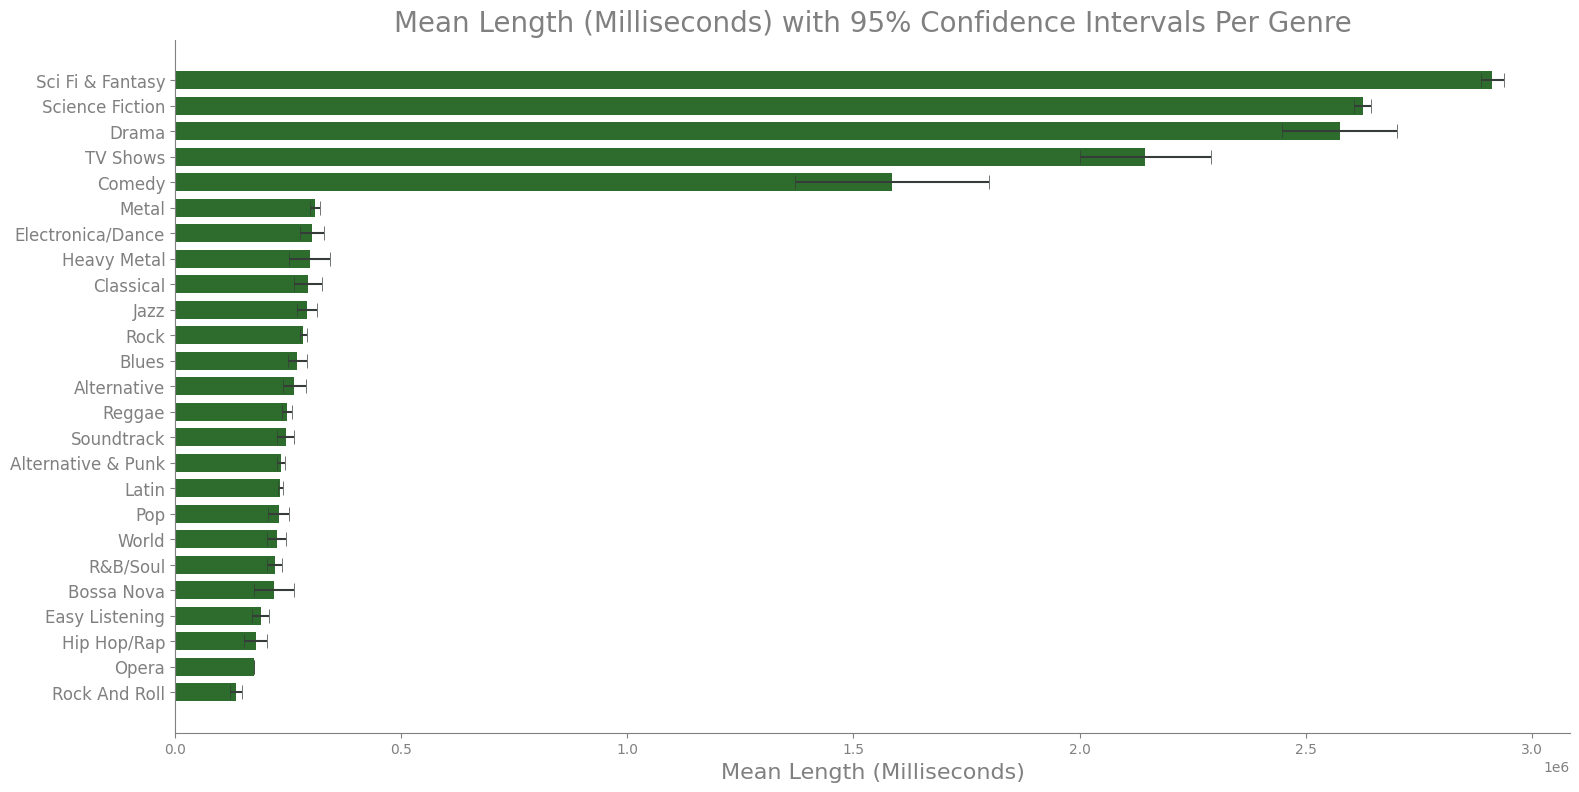

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9))

grp_df_track_genre['LowerError'] = grp_df_track_genre['MeanLength'] - grp_df_track_genre['LowerCI']
grp_df_track_genre['UpperError'] = grp_df_track_genre['UpperCI'] - grp_df_track_genre['MeanLength']


ax.barh(grp_df_track_genre['NameGenre'], 
        grp_df_track_genre['MeanLength'],
        height=0.7,
        align='center',
        color="#2e6c2e")

ax.errorbar(
    y=range(len(grp_df_track_genre)),
    x=grp_df_track_genre['MeanLength'],
    xerr=[grp_df_track_genre['LowerError'], grp_df_track_genre['UpperError']],
    fmt='none', ecolor='#363d39', capsize=5, capthick=0.5
)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')


ax.set_title('Mean Length (Milliseconds) with 95% Confidence Intervals Per Genre',  fontsize=20, loc="center", color="gray")
ax.set_xlabel('Mean Length (Milliseconds)', fontsize=16, color='gray', loc='center')


plt.yticks(fontsize=12) 
plt.show()

## Average sales in different countries

In [348]:
grp_df_invoice = (df_invoice
                .groupby(by=['BillingCountry'], as_index=False)
                .agg(AvgSells=('Total', 'mean'), CountLength=('Total', 'count'))
                .sort_values(by=['AvgSells']))
                
grp_df_invoice['AvgSells'] = grp_df_invoice['AvgSells'].round(3)

grp_df_invoice[['LowerCI', 'UpperCI']] = grp_df_invoice.apply(
                lambda df: pd.Series(confidence(df_invoice[df_invoice['BillingCountry'] == df['BillingCountry']]['Total'], df['CountLength'])),
                axis=1
            )
            
grp_df_invoice = grp_df_invoice.drop(['CountLength'], axis=1)
grp_df_invoice

,BillingCountry,AvgSells,LowerCI,UpperCI
20,Spain,5.374,1.084,9.664
18,Poland,5.374,1.084,9.664
3,Belgium,5.374,1.084,9.664
0,Argentina,5.374,1.084,9.664
15,Italy,5.374,1.084,9.664
8,Denmark,5.374,1.084,9.664
23,United Kingdom,5.374,3.371,7.377
1,Australia,5.374,1.084,9.664
5,Canada,5.428,4.294,6.562
4,Brazil,5.431,3.999,6.864


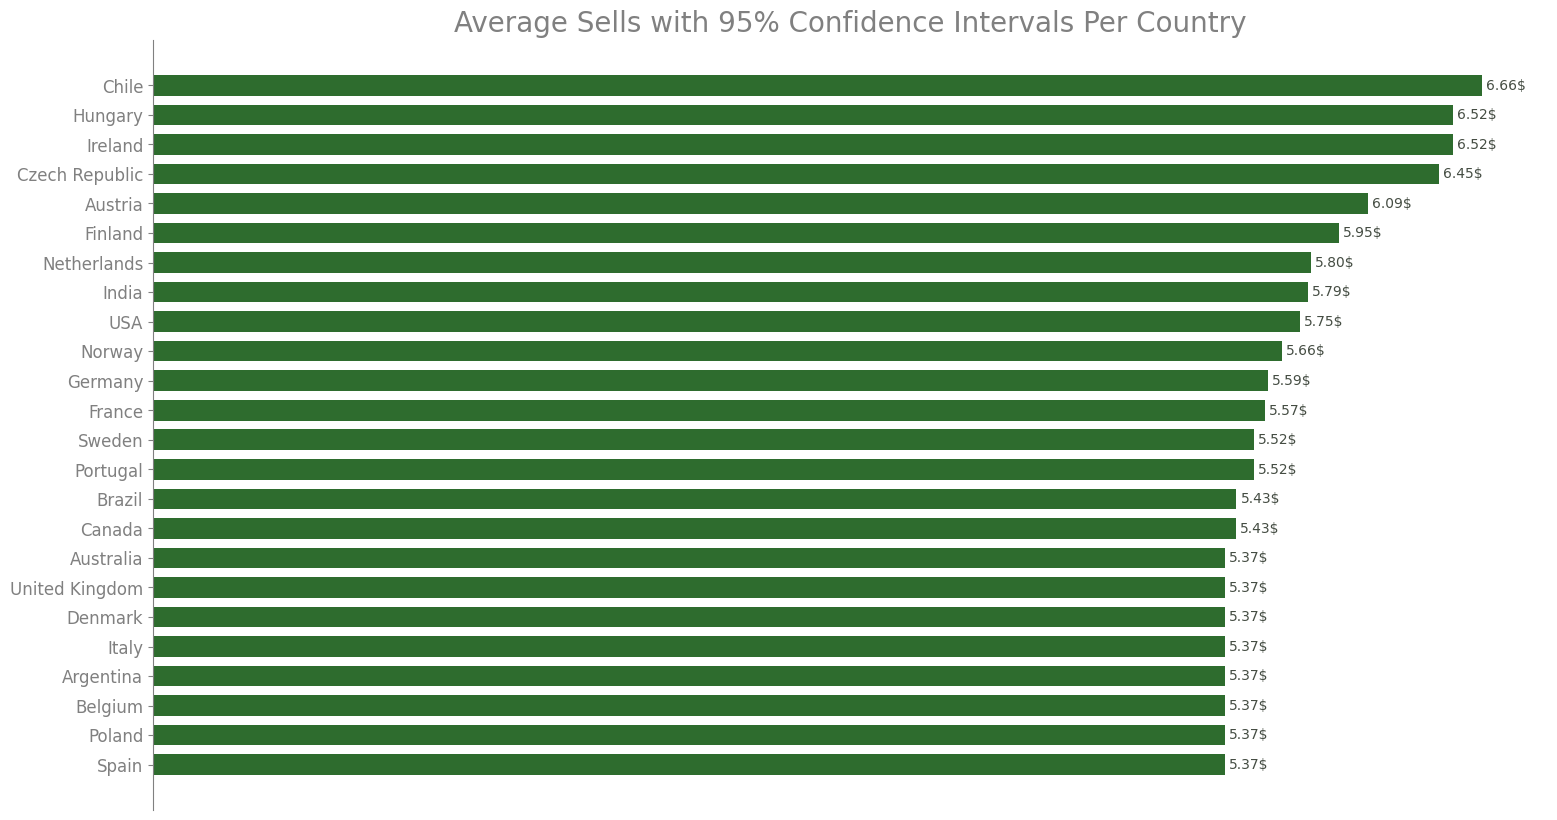

In [360]:
fig, ax = plt.subplots(figsize=(18, 10))


bars = ax.barh(grp_df_invoice['BillingCountry'], 
        grp_df_invoice['AvgSells'],
        height=0.7,
        align='center',
        color="#2e6c2e")

ax.bar_label(bars, fmt='%.2f$', fontsize=10, color='#454d43', padding=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')

ax.set_title('Average Sells with 95% Confidence Intervals Per Country',  fontsize=20, loc="center", color="gray")

plt.yticks(fontsize=12) 
plt.xticks([])
plt.show()

## Average number of songs purchased by each user

In [365]:
grp_number_buy = df_invoiceline_invoice_customer.groupby(by=['CustomerId'], as_index=False).agg(AvgPurchased=('Quantity', 'mean'),
                                                                                                CountLength=('Quantity', 'count'))

grp_number_buy[['LowerCI', 'UpperCI']] = grp_number_buy.apply(
                lambda df: pd.Series(confidence(df_invoiceline_invoice_customer[df_invoiceline_invoice_customer['CustomerId'] == df['CustomerId']]['Quantity']
                                                , size=df['CountLength']))
                ,axis=1
            )
            
grp_number_buy = grp_number_buy.drop(['CountLength'], axis=1)
grp_number_buy

,CustomerId,AvgPurchased,LowerCI,UpperCI
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,1.0,1.0
4,5,1.0,1.0,1.0
5,6,1.0,1.0,1.0
6,7,1.0,1.0,1.0
7,8,1.0,1.0,1.0
8,9,1.0,1.0,1.0
9,10,1.0,1.0,1.0
